In [3]:
import pandas as pd
import numpy as np
import spacy
import nltk
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from string import punctuation
stop_words = set( stopwords.words('english'))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

spacy.load('en_core_web_lg')

import os
from os import walk
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import numpy as np
import seaborn as sns

tqdm_notebook.pandas()


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rchaks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rchaks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rchaks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/rchaks/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Identify Fallen Angels

In [2]:
pd.read_csv('data_files/all_downgrades.csv', low_memory= False, nrows = 100).head()

,gvkey,splticrm,datadate,busdesc,cik,ggroup,gind,gsector,sic,conm,tic,cusip
0,1003,NaN,20040630,"A.A. Importing Company, Inc. designs, manufact...",730052,2550,255040,25,5712,A.A. IMPORTING CO INC,ANTQ,354100
1,1003,NaN,20040731,"A.A. Importing Company, Inc. designs, manufact...",730052,2550,255040,25,5712,A.A. IMPORTING CO INC,ANTQ,354100
2,1003,NaN,20040831,"A.A. Importing Company, Inc. designs, manufact...",730052,2550,255040,25,5712,A.A. IMPORTING CO INC,ANTQ,354100
3,1003,NaN,20040930,"A.A. Importing Company, Inc. designs, manufact...",730052,2550,255040,25,5712,A.A. IMPORTING CO INC,ANTQ,354100
4,1003,NaN,20041031,"A.A. Importing Company, Inc. designs, manufact...",730052,2550,255040,25,5712,A.A. IMPORTING CO INC,ANTQ,354100


In [3]:
used_cols = ['gvkey','splticrm', 'datadate', 'cik','gsector','tic']

df = pd.read_csv('data_files/all_downgrades.csv',  usecols= used_cols)#.drop(['rating_drop','Next Filing Rating'], axis=1)
# df.rename(columns={
#     'Next Filing Rating': 'next_splticrm'
#     }, inplace=True)

df['datadate'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df['year'] = df['datadate'].dt.year
df = df.set_index('datadate')

df['next_splticrm'] = df.groupby(['gvkey'])['splticrm'].shift(-1)
df.dropna(inplace=True)
df

,gvkey,splticrm,cik,gsector,tic,year,next_splticrm
datadate,,,,,,,
2000-01-31,1004,BBB,1750.0,20.0,AIR,2000,BBB
2000-02-29,1004,BBB,1750.0,20.0,AIR,2000,BBB
2000-03-31,1004,BBB,1750.0,20.0,AIR,2000,BBB
2000-04-30,1004,BBB,1750.0,20.0,AIR,2000,BBB
2000-05-31,1004,BBB,1750.0,20.0,AIR,2000,BBB
...,...,...,...,...,...,...,...
2016-09-30,316056,BBB-,1579241.0,20.0,ALLE,2016,BBB-
2016-10-31,316056,BBB-,1579241.0,20.0,ALLE,2016,BBB-
2016-11-30,316056,BBB-,1579241.0,20.0,ALLE,2016,BBB-


In [4]:
# df = pd.read_csv('consumer_staples.csv')#.drop('Unnamed: 0', axis = 1)
# df['datadate'] = pd.to_datetime(df['datadate'])
# df['year'] = df['datadate'].dt.year

# df = df.set_index('datadate')
# df = df.dropna(subset = ['splticrm'])

# df['next_splticrm'] = df.groupby(['gvkey'])['splticrm'].shift(-1)
# # df = df.dropna(subset = ['next_splticrm'])

# df.dropna(inplace=True)
# df

In [5]:
df.splticrm.value_counts().index

Index(['BBB', 'BBB+', 'BBB-', 'B+', 'BB-', 'A-', 'B', 'BB', 'A', 'BB+', 'A+',
       'B-', 'AA-', 'CCC+', 'AA', 'D', 'CCC', 'AAA', 'AA+', 'CC', 'CCC-',
       'SD'],
      dtype='object')

In [6]:
def is_invest_grade(rating: str)->bool:
    return rating.startswith('A') or rating in {'BBB','BBB+'}

def junk_drop(rating:pd.Series, next_rating:pd.Series)->pd.Series:
    out = []
    for item in zip(rating, next_rating):
        grade = 'invest'
        if is_invest_grade(item[0]) == True:
            if is_invest_grade(item[1]) == False:
                grade = 'fallen'
        else:
            grade = 'junk'
        
        out.append(grade)
    return out


df['grade'] = junk_drop(df['splticrm'],df['next_splticrm'])
df

,gvkey,splticrm,cik,gsector,tic,year,next_splticrm,grade
datadate,,,,,,,,
2000-01-31,1004,BBB,1750.0,20.0,AIR,2000,BBB,invest
2000-02-29,1004,BBB,1750.0,20.0,AIR,2000,BBB,invest
2000-03-31,1004,BBB,1750.0,20.0,AIR,2000,BBB,invest
2000-04-30,1004,BBB,1750.0,20.0,AIR,2000,BBB,invest
2000-05-31,1004,BBB,1750.0,20.0,AIR,2000,BBB,invest
...,...,...,...,...,...,...,...,...
2016-09-30,316056,BBB-,1579241.0,20.0,ALLE,2016,BBB-,junk
2016-10-31,316056,BBB-,1579241.0,20.0,ALLE,2016,BBB-,junk
2016-11-30,316056,BBB-,1579241.0,20.0,ALLE,2016,BBB-,junk


In [7]:
df.grade.value_counts()

junk      226526
invest    185276
fallen       640
Name: grade, dtype: int64

In [8]:
def compare(x):
    '''
    Returns recods of Sectors where there is at least one fallen angel 
    '''
    return any(x=='fallen') # Returns True if any item in the security is 'fallen' in given year and industry

In [9]:
df = df.reset_index().set_index(['year','gsector'])[df.groupby(['year','gsector'])['grade'].apply(compare)].reset_index()
df = df[df.grade != 'junk']  # discarding junk bonds
df = df.set_index('datadate')
df

/var/folders/y3/v6fyb_rs72bcn7ftc3lvwvmw0000gn/T/ipykernel_43618/910460148.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.reset_index().set_index(['year','gsector'])[df.groupby(['year','gsector'])['grade'].apply(compare)].reset_index()


,year,gsector,gvkey,splticrm,cik,tic,next_splticrm,grade
datadate,,,,,,,,
2000-01-31,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest
2000-02-29,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest
2000-03-31,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest
2000-04-30,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest
2000-05-31,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest
...,...,...,...,...,...,...,...,...
2016-08-31,2016,10.0,287882,BBB,1444406.0,EC,BBB,invest
2016-09-30,2016,10.0,287882,BBB,1444406.0,EC,BBB,invest
2016-10-31,2016,10.0,287882,BBB,1444406.0,EC,BBB,invest


In [10]:
df.groupby(['gsector','year','grade']).size().unstack().to_csv('check_downgrades.csv')
df.groupby(['year','gsector','grade']).size().unstack()

grade         fallen  invest
year gsector                
2000 10.0          3     989
     15.0          8    1052
     20.0          5    1386
     25.0          9    1040
     35.0          3     585
...              ...     ...
2016 40.0          2    2110
     45.0          1     559
     55.0          2    2090
     60.0          1     507
2017 25.0          1      53

[161 rows x 2 columns]

In [11]:
with open('gvkeys.txt', 'w') as f:
    [f.write(str(x)+'\n') for x in df.gvkey.unique()]

# Annuals Data

In [12]:
subset_cols = ['gvkey',
# 'conm',
# 'ggroup',
'datadate',
'fyear',
'indfmt',
'consol',
'popsrc',
'datafmt',
'tic',
'curcd',
'at',
'gp',
'invt',
'nits',
'oiadp',
'revt',
'txt',
'cik',
'costat',
'mkvalt']

In [13]:
annual_data = pd.read_csv('data_files/annuals_data.csv', low_memory= False, usecols = subset_cols)
# fill na ciks
annual_data['datadate'] = pd.to_datetime(annual_data['datadate'])
annual_data['fyear'] = annual_data['datadate'].dt.year
print(annual_data.shape)
annual_data.head()

(31432, 19)


,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,at,gp,invt,nits,oiadp,revt,txt,cik,costat,mkvalt
0,1004,2000-05-31,2000,INDL,C,D,STD,AIR,USD,740.998,191.226,336.018,NaN,70.658,1024.333,14.363,1750,A,372.7519
1,1004,2001-05-31,2001,INDL,C,D,STD,AIR,USD,701.854,160.444,320.590,NaN,45.790,874.255,1.689,1750,A,377.1180
2,1004,2002-05-31,2002,INDL,C,D,STD,AIR,USD,710.199,112.244,286.588,NaN,4.711,638.721,-39.290,1750,A,364.5928
3,1004,2003-05-31,2003,INDL,C,D,STD,AIR,USD,686.621,109.590,259.954,NaN,3.573,606.337,-7.080,1750,A,143.3295
4,1004,2004-05-31,2004,INDL,C,D,STD,AIR,USD,709.292,128.656,247.245,NaN,20.811,651.958,-1.797,1750,A,308.9071


In [14]:
annual_data.gvkey.unique().shape

(1566,)

In [15]:
annual_data.isna().sum()['cik']

0

In [16]:
merged_data = pd.merge(df.reset_index(),annual_data.drop(['datadate','tic','cik'],axis= 1), how = 'left', left_on = ['gvkey','year'], right_on = ['gvkey','fyear'])
merged_data.shape

(203316, 24)

In [17]:
merged_data.describe()

,year,gsector,gvkey,cik,fyear,at,gp,invt,nits,oiadp,revt,txt,mkvalt
count,203316.000000,203316.000000,203316.000000,2.033160e+05,189319.000000,1.890520e+05,153779.000000,158848.000000,8.772000e+03,153779.000000,189047.000000,189047.000000,108882.000000
mean,2007.684939,37.174841,39120.309961,6.622253e+05,2007.721861,9.941891e+04,5758.811292,3521.507943,6.325947e+03,2662.071302,16221.744779,557.593785,21333.377936
std,4.971202,14.102271,55965.888190,5.096058e+05,4.969608,3.047192e+05,11356.389007,23852.875831,1.099641e+05,6202.161648,31735.686424,1505.660549,42708.843197
min,2000.000000,10.000000,1004.000000,1.750000e+03,2000.000000,1.390300e+01,-76735.000000,0.000000,-4.056000e+03,-80053.000000,-15009.328000,-20612.000000,4.595200
25%,2003.000000,25.000000,6682.000000,7.846000e+04,2003.000000,4.856499e+03,585.317000,7.000000,9.500000e+01,279.805000,1700.892000,38.780000,2807.629300
50%,2007.000000,40.000000,13135.000000,8.042120e+05,2008.000000,1.411921e+04,1680.004000,213.690000,3.684000e+02,783.748000,4706.000000,153.031000,7312.415200
75%,2012.000000,45.000000,30436.000000,1.050825e+06,2012.000000,4.482100e+04,5198.463000,1033.582000,8.221000e+02,2247.000000,15345.000000,509.000000,20157.494500
max,2017.000000,60.000000,287882.000000,1.841666e+06,2017.000000,3.771200e+06,127608.000000,472266.229000,2.535000e+06,91996.871000,483521.000000,31045.000000,615336.455900


In [18]:
merged_data.head()

,datadate,year,gsector,gvkey,splticrm,cik,tic,next_splticrm,grade,fyear,...,curcd,at,gp,invt,nits,oiadp,revt,txt,costat,mkvalt
0,2000-01-31,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest,2000.0,...,USD,740.998,191.226,336.018,NaN,70.658,1024.333,14.363,A,372.7519
1,2000-02-29,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest,2000.0,...,USD,740.998,191.226,336.018,NaN,70.658,1024.333,14.363,A,372.7519
2,2000-03-31,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest,2000.0,...,USD,740.998,191.226,336.018,NaN,70.658,1024.333,14.363,A,372.7519
3,2000-04-30,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest,2000.0,...,USD,740.998,191.226,336.018,NaN,70.658,1024.333,14.363,A,372.7519
4,2000-05-31,2000,20.0,1004,BBB,1750.0,AIR,BBB,invest,2000.0,...,USD,740.998,191.226,336.018,NaN,70.658,1024.333,14.363,A,372.7519


In [19]:
# original

fallen_angels = merged_data[['gvkey','gsector','year','tic','cik','datadate','grade']].drop_duplicates()
fallen_angels.cik = fallen_angels.cik.astype(int)
fallen_angels.year = fallen_angels.year.astype(int)
fallen_angels.gsector = fallen_angels.gsector.astype(int)
fallen_angels.to_csv('data_files/fallen_angels.csv', index= False)
print(fallen_angels.grade.value_counts())
fallen_angels

invest    167259
fallen       640
Name: grade, dtype: int64


,gvkey,gsector,year,tic,cik,datadate,grade
0,1004,20,2000,AIR,1750,2000-01-31,invest
1,1004,20,2000,AIR,1750,2000-02-29,invest
2,1004,20,2000,AIR,1750,2000-03-31,invest
3,1004,20,2000,AIR,1750,2000-04-30,invest
4,1004,20,2000,AIR,1750,2000-05-31,invest
...,...,...,...,...,...,...,...
203311,287882,10,2016,EC,1444406,2016-08-31,invest
203312,287882,10,2016,EC,1444406,2016-09-30,invest
203313,287882,10,2016,EC,1444406,2016-10-31,invest
203314,287882,10,2016,EC,1444406,2016-11-30,invest


grade,fallen,invest
gsector,,
10,66,11676
15,75,13325
20,76,19311
25,80,11353
30,22,7198
35,24,7220
40,103,43341
45,43,8164
50,38,7120


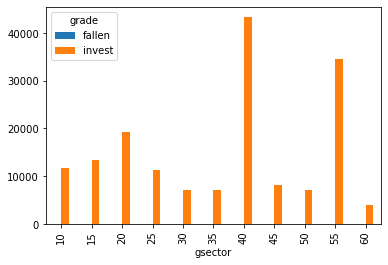

In [20]:
# fallen_angels.grade.value_counts()
fallen_angels.groupby(['gsector','grade']).size().unstack().plot(kind = 'bar')
fallen_angels.groupby(['gsector','grade']).size().unstack()

# Scrape Edgar

In [62]:
import os
from ut_msba_edgar_scraper import Downloader
from datetime import datetime
import itertools
from tqdm import tqdm

In [99]:
fallen_angels = pd.read_csv('data_files/fallen_angels.csv')
fallen_angels.datadate = pd.to_datetime(fallen_angels.datadate)
fallen_angels.year = fallen_angels.year.astype(int)
fallen_angels = fallen_angels[fallen_angels.datadate.dt.year >= 2000]
fallen_angels

,gvkey,gsector,year,tic,cik,datadate,grade
0,1004,20,2000,AIR,1750,2000-01-31,invest
1,1004,20,2000,AIR,1750,2000-02-29,invest
2,1004,20,2000,AIR,1750,2000-03-31,invest
3,1004,20,2000,AIR,1750,2000-04-30,invest
4,1004,20,2000,AIR,1750,2000-05-31,invest
...,...,...,...,...,...,...,...
167894,287882,10,2016,EC,1444406,2016-08-31,invest
167895,287882,10,2016,EC,1444406,2016-09-30,invest
167896,287882,10,2016,EC,1444406,2016-10-31,invest
167897,287882,10,2016,EC,1444406,2016-11-30,invest


In [100]:
fallen_angels.groupby(['year', 'gsector'])['grade'].value_counts().unstack()

grade         fallen  invest
year gsector                
2000 10            3     989
     15            8    1052
     20            5    1386
     25            9    1040
     35            3     585
...              ...     ...
2016 40            2    2110
     45            1     559
     55            2    2090
     60            1     507
2017 25            1      53

[161 rows x 2 columns]

In [101]:
fallen_angels

,gvkey,gsector,year,tic,cik,datadate,grade
0,1004,20,2000,AIR,1750,2000-01-31,invest
1,1004,20,2000,AIR,1750,2000-02-29,invest
2,1004,20,2000,AIR,1750,2000-03-31,invest
3,1004,20,2000,AIR,1750,2000-04-30,invest
4,1004,20,2000,AIR,1750,2000-05-31,invest
...,...,...,...,...,...,...,...
167894,287882,10,2016,EC,1444406,2016-08-31,invest
167895,287882,10,2016,EC,1444406,2016-09-30,invest
167896,287882,10,2016,EC,1444406,2016-10-31,invest
167897,287882,10,2016,EC,1444406,2016-11-30,invest


In [108]:
scrape_edgar = fallen_angels.groupby(['gvkey','gsector','year','tic','cik','grade'])['datadate'].max().reset_index()
scrape_edgar.datadate = pd.to_datetime(scrape_edgar.datadate)
scrape_edgar

,gvkey,gsector,year,tic,cik,grade,datadate
0,1004,20,2000,AIR,1750,invest,2000-12-31
1,1004,20,2001,AIR,1750,fallen,2001-12-31
2,1004,20,2001,AIR,1750,invest,2001-11-30
3,1036,20,2000,UDI.,29590,invest,2000-12-31
4,1036,20,2001,UDI.,29590,invest,2001-03-31
...,...,...,...,...,...,...,...
15591,266257,40,2016,AINV,1278752,fallen,2016-01-31
15592,287882,10,2013,EC,1444406,invest,2013-12-31
15593,287882,10,2014,EC,1444406,invest,2014-12-31
15594,287882,10,2015,EC,1444406,invest,2015-12-31


In [109]:
def fetch_reports(args):
    downloader = Downloader()
    report_type, date, gvkey, grade = args
    after_date = datetime(year= max(date.year-1, 2000), month=1, day=1)
    
    try:
        filings_list = downloader.get_filings(report_type,
                                            gvkey, 
                                            before= date.strftime('%Y-%m-%d'),
                                            after = after_date.strftime('%Y-%m-%d'))
        
        #option -1
        for filing in filings_list[::-1]:
            os.makedirs(f'data/raw/{grade}/', exist_ok=True)
            with open(f'data/raw/{grade}/{repr(filing)}.html','wb') as f:
                f.write(filing.get_report())
    
    except Exception as e:
        print(f'Failed {gvkey},{report_type},{date},{after_date}',str(e))
    

In [122]:
os.makedirs('fallen_angels/raw', exist_ok = True)

cached_reports = {}
total = cache_miss = 0

counter = 0
# for _ in itertools.product(fallen_angels.values.tolist(), ['10-K','10-Q']):
for _ in itertools.product(scrape_edgar.values.tolist(), ['10-K','10-Q']):
    counter += 1

# for rows, report_type in (pbar:=tqdm(itertools.product(fallen_angels.values.tolist(), ['10-K','10-Q']), total= counter)):
for rows, report_type in (pbar:=tqdm(itertools.product(scrape_edgar.values.tolist(), ['10-K','10-Q']), total= counter)):

    gvkey, gsector, year, ticker, cik, grade, date = rows
    # pbar.set_description(f"{report_type}, {date.strftime('%Y-%m-%d')}, {ticker}, {grade}")
 
    if gvkey not in cached_reports:                             ## GVKEY is not in the cache
        cached_reports[gvkey] = set()
    
    if year not in cached_reports[gvkey]:                           ## year is NOT in the cache
        cache_miss += 1
        date = datetime(year=date.year, month=12, day=31)
        fetch_reports((report_type, date, gvkey, grade))
        cached_reports[gvkey].add(year)

    if year - 1 not in cached_reports[gvkey]:                       ## year - 1 is NOT in the cache
        cache_miss += 1
        date = datetime(year=max(2000, date.year - 1), month=12, day=31)
        fetch_reports((report_type, date, gvkey, grade))
        cached_reports[gvkey].add(year-1)
    total += 2

  1%|          | 209/31192 [08:56<85:34:14,  9.94s/it]

Failed 1238,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1238" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1238,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1238" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1238,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1238" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1238,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "1238" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


  1%|          | 253/31192 [09:38<13:11:33,  1.54s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000003370/000103605000002184/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000003370/000103605000002184/0001.txt.
Failed 1246,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 255/31192 [09:40<12:12:11,  1.42s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000003370/000103605000002184/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000003370/000103605000002184/0001.txt.
Failed 1246,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 257/31192 [09:41<10:06:01,  1.18s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000003370/000103605000002184/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000003370/000103605000002184/0001.txt.
Failed 1246,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 303/31192 [11:42<24:46:14,  2.89s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt.
Failed 1300,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 307/31192 [11:44<15:27:22,  1.80s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt.
Failed 1300,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 309/31192 [11:45<13:00:49,  1.52s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt.
Failed 1300,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 311/31192 [11:47<12:00:21,  1.40s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000773840/000095011701000640/0001.txt.
Failed 1300,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 351/31192 [13:53<25:43:14,  3.00s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000004310/000000431001000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000004310/000000431001000005/0001.txt.
Failed 1359,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 355/31192 [13:55<15:35:10,  1.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000004310/000000431001000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000004310/000000431001000005/0001.txt.
Failed 1359,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  1%|          | 357/31192 [13:56<12:40:33,  1.48s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000004310/000000431001000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000004310/000000431001000005/0001.txt.
Failed 1359,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 705/31192 [27:15<19:59:36,  2.36s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt.
Failed 1602,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 707/31192 [27:17<16:27:55,  1.94s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt.
Failed 1602,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 709/31192 [27:18<13:12:04,  1.56s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt.
Failed 1602,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 711/31192 [27:21<12:45:49,  1.51s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000318154/000089843001000873/0001.txt.
Failed 1602,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 729/31192 [28:14<23:11:23,  2.74s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt.
Failed 1619,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 731/31192 [28:16<18:46:12,  2.22s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt.
Failed 1619,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 733/31192 [28:18<14:37:26,  1.73s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt.
Failed 1619,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  2%|▏         | 735/31192 [28:19<12:31:42,  1.48s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000003133/000093176301000676/0001.txt.
Failed 1619,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 911/31192 [33:14<16:47:17,  2.00s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000007084/000000708400000039/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000007084/000000708400000039/0001.txt.
Failed 1722,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 913/31192 [33:17<15:16:16,  1.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000007084/000000708400000039/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000007084/000000708400000039/0001.txt.
Failed 1722,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 933/31192 [34:00<21:57:05,  2.61s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt.
Failed 1738,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 935/31192 [34:02<17:52:50,  2.13s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt.
Failed 1738,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 937/31192 [34:03<14:10:42,  1.69s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt.
Failed 1738,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 939/31192 [34:05<12:03:01,  1.43s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000007214/000000721401000002/0001.txt.
Failed 1738,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 981/31192 [35:34<12:03:12,  1.44s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 1745,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 985/31192 [35:35<8:15:39,  1.02it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 1745,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 987/31192 [35:36<7:03:46,  1.19it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 1745,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 989/31192 [35:39<7:54:18,  1.06it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 1745,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  3%|▎         | 1039/31192 [39:56<5:39:47,  1.48it/s] 

Failed 1803,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1803,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1803,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1803,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "1803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1803,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "1803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1803,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "1803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1828,10-K,2001-12-31 00:00:00,200

  4%|▎         | 1115/31192 [41:37<37:58:03,  4.54s/it]

Failed 1848,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1848" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 1848,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "1848" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


  4%|▎         | 1137/31192 [42:15<17:19:49,  2.08s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000008670/000000867000000026/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000008670/000000867000000026/0001.txt.
Failed 1891,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▎         | 1139/31192 [42:18<15:09:41,  1.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000008670/000000867000000026/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000008670/000000867000000026/0001.txt.
Failed 1891,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▎         | 1141/31192 [42:19<11:55:11,  1.43s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000008670/000000867000000026/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000008670/000000867000000026/0001.txt.
Failed 1891,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▍         | 1211/31192 [43:48<9:56:44,  1.19s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000008868/000000886801000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000008868/000000886801000003/0001.txt.
Failed 1920,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▍         | 1215/31192 [43:51<8:36:07,  1.03s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000008868/000000886801000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000008868/000000886801000003/0001.txt.
Failed 1920,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▍         | 1217/31192 [43:55<10:12:14,  1.23s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000008868/000000886801000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000008868/000000886801000003/0001.txt.
Failed 1920,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▍         | 1299/31192 [45:43<19:38:17,  2.37s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt.
Failed 1995,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▍         | 1301/31192 [45:45<16:37:37,  2.00s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt.
Failed 1995,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▍         | 1303/31192 [45:48<14:47:49,  1.78s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt.
Failed 1995,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  4%|▍         | 1305/31192 [45:52<16:17:46,  1.96s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000009466/000095016901000114/0001.txt.
Failed 1995,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  5%|▌         | 1575/31192 [52:17<11:30:44,  1.40s/it]

Failed 2137,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2137" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2137,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2137" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2137,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "2137" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2137,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2137" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2137,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "2137" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2137,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "2137" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2137,10-K,2005-12-31 00:00:00,200

  6%|▌         | 1849/31192 [1:00:07<25:44:52,  3.16s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt.
Failed 2285,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  6%|▌         | 1853/31192 [1:00:09<15:56:08,  1.96s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt.
Failed 2285,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  6%|▌         | 1855/31192 [1:00:10<13:23:53,  1.64s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt.
Failed 2285,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  6%|▌         | 1857/31192 [1:00:12<12:08:00,  1.49s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000012927/000001292701000004/0001.txt.
Failed 2285,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  6%|▋         | 2017/31192 [1:04:07<30:04:37,  3.71s/it]

Failed 2408,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2408" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2408,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2408" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2408,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "2408" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2408,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2408" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2408,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "2408" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2408,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "2408" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2408,10-K,2005-12-31 00:00:00,200

  7%|▋         | 2097/31192 [1:04:21<2:02:32,  3.96it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000014693/000001469300000016/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000014693/000001469300000016/0001.txt.
Failed 2435,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2099/31192 [1:04:23<4:05:05,  1.98it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000014693/000001469300000016/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000014693/000001469300000016/0001.txt.
Failed 2435,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2119/31192 [1:04:49<11:41:10,  1.45s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt.
Failed 2444,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2121/31192 [1:04:51<10:41:01,  1.32s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt.
Failed 2444,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2123/31192 [1:04:52<8:35:01,  1.06s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt.
Failed 2444,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2125/31192 [1:04:54<7:53:11,  1.02it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000014930/000095013101001498/0001.txt.
Failed 2444,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2143/31192 [1:05:28<11:22:17,  1.41s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt.
Failed 2490,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2147/31192 [1:05:30<8:33:59,  1.06s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt.
Failed 2490,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2149/31192 [1:05:31<7:43:34,  1.04it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt.
Failed 2490,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2151/31192 [1:05:34<8:29:35,  1.05s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000934612/000093066101000296/0001.txt.
Failed 2490,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2179/31192 [1:06:39<15:55:59,  1.98s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt.
Failed 2497,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2181/31192 [1:06:41<14:14:45,  1.77s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt.
Failed 2497,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2183/31192 [1:06:43<11:23:52,  1.41s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt.
Failed 2497,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2185/31192 [1:06:44<10:07:47,  1.26s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000015615/000001561501000001/0001.txt.
Failed 2497,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2211/31192 [1:06:56<4:03:40,  1.98it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt.
Failed 2549,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2213/31192 [1:06:59<5:32:58,  1.45it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt.
Failed 2549,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2215/31192 [1:07:00<5:02:23,  1.60it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt.
Failed 2549,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2217/31192 [1:07:01<4:45:32,  1.69it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000020388/000089109201000463/0001.txt.
Failed 2549,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2231/31192 [1:07:41<24:01:37,  2.99s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt.
Failed 2574,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2233/31192 [1:07:43<19:51:27,  2.47s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt.
Failed 2574,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2235/31192 [1:07:44<15:41:41,  1.95s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt.
Failed 2574,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2237/31192 [1:07:46<13:34:05,  1.69s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000277948/000102140801001422/0001.txt.
Failed 2574,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2309/31192 [1:10:00<3:06:37,  2.58it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt.
Failed 2620,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2311/31192 [1:10:01<4:05:21,  1.96it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt.
Failed 2620,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2313/31192 [1:10:03<4:27:27,  1.80it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt.
Failed 2620,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  7%|▋         | 2315/31192 [1:10:04<5:06:02,  1.57it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001011659/000109230601000069/0001.txt.
Failed 2620,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  8%|▊         | 2343/31192 [1:11:58<40:34:30,  5.06s/it]

Failed 2647,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2647" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2647,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2647" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


  8%|▊         | 2429/31192 [1:12:38<1:09:47,  6.87it/s] 

Failed 2696,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2696" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2696,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2696" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2696,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2696" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2696,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "2696" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2696,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "2696" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2696,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "2696" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2696,10-K,2005-12-31 00:00:00,200

  8%|▊         | 2557/31192 [1:18:01<79:10:28,  9.95s/it]

Failed 2784,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2784" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2784,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2784" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000017843/000001784300000021/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000017843/000001784300000021/0001.htm.
Failed 2787,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  8%|▊         | 2561/31192 [1:18:04<44:36:04,  5.61s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000017843/000001784300000021/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000017843/000001784300000021/0001.htm.
Failed 2787,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  8%|▊         | 2563/31192 [1:18:04<34:20:31,  4.32s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000017843/000001784300000021/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000017843/000001784300000021/0001.htm.
Failed 2787,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▊         | 2687/31192 [1:21:32<36:09:55,  4.57s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt.
Failed 2859,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▊         | 2691/31192 [1:21:34<21:40:07,  2.74s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt.
Failed 2859,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▊         | 2693/31192 [1:21:36<18:31:50,  2.34s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt.
Failed 2859,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▊         | 2695/31192 [1:21:39<16:34:58,  2.09s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001089819/000089924301000762/0001.txt.
Failed 2859,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2755/31192 [1:24:00<2:02:24,  3.87it/s] 

Failed 2866,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2866" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2866,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2866" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt.
Failed 2884,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2759/31192 [1:24:02<2:57:32,  2.67it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt.
Failed 2884,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment
Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt.
Failed 2884,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2761/31192 [1:24:06<5:25:27,  1.46it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000018926/000001892601000002/0001.txt.
Failed 2884,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2771/31192 [1:24:24<14:24:17,  1.82s/it]

Failed 2917,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2917" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 2917,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "2917" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


  9%|▉         | 2853/31192 [1:28:25<2:03:55,  3.81it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt.
Failed 2991,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2855/31192 [1:28:27<3:40:13,  2.14it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt.
Failed 2991,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2857/31192 [1:28:28<3:43:25,  2.11it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt.
Failed 2991,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2859/31192 [1:28:31<6:25:29,  1.22it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000093410/000009341001000015/0001.txt.
Failed 2991,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2883/31192 [1:30:14<28:06:46,  3.58s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000703351/000070335100000013/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000703351/000070335100000013/0001.txt.
Failed 3007,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


  9%|▉         | 2903/31192 [1:30:43<20:01:11,  2.55s/it]

Failed 3023,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3023" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3023,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3023" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 10%|▉         | 3073/31192 [1:40:19<35:57:07,  4.60s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000719547/000101540200002557/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000719547/000101540200002557/0001.txt.
Failed 3103,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|▉         | 3075/31192 [1:40:21<27:24:58,  3.51s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000719547/000101540200002557/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000719547/000101540200002557/0001.txt.
Failed 3103,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|▉         | 3077/31192 [1:40:22<20:31:22,  2.63s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000719547/000101540200002557/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000719547/000101540200002557/0001.txt.
Failed 3103,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|▉         | 3081/31192 [1:40:25<13:01:08,  1.67s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000021076/000002107600000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000021076/000002107600000003/0001.txt.
Failed 3121,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|▉         | 3083/31192 [1:40:27<11:50:16,  1.52s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000021076/000002107600000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000021076/000002107600000003/0001.txt.
Failed 3121,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|▉         | 3109/31192 [1:40:56<6:01:35,  1.29it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000317540/000095016801000629/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000317540/000095016801000629/0001.txt.
Failed 3138,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|▉         | 3113/31192 [1:40:59<5:24:01,  1.44it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000317540/000095016801000629/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000317540/000095016801000629/0001.txt.
Failed 3138,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|▉         | 3115/31192 [1:41:04<9:25:49,  1.21s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000317540/000095016801000629/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000317540/000095016801000629/0001.txt.
Failed 3138,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|█         | 3133/31192 [1:41:52<19:29:43,  2.50s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000021344/000002134401000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000021344/000002134401000005/0001.txt.
Failed 3144,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|█         | 3135/31192 [1:41:54<16:25:43,  2.11s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000021344/000002134401000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000021344/000002134401000005/0001.txt.
Failed 3144,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|█         | 3137/31192 [1:41:58<16:10:42,  2.08s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000021344/000002134401000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000021344/000002134401000005/0001.txt.
Failed 3144,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|█         | 3223/31192 [1:44:58<12:12:48,  1.57s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt.
Failed 3221,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|█         | 3225/31192 [1:45:00<10:40:47,  1.37s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt.
Failed 3221,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|█         | 3227/31192 [1:45:01<8:45:55,  1.13s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt.
Failed 3221,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 10%|█         | 3229/31192 [1:45:03<9:24:36,  1.21s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000315293/000094857201000011/0001.txt.
Failed 3221,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 11%|█         | 3395/31192 [1:53:25<11:33:43,  1.50s/it]

Failed 3255,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3255" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3255,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3255" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3256,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3256" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3256,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3256" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3259,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3259" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3259,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3259" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3273,10-K,2000-12-31 00:00:00,200

 11%|█         | 3421/31192 [1:53:55<15:55:46,  2.06s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt.
Failed 3282,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 11%|█         | 3423/31192 [1:53:58<14:14:06,  1.85s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt.
Failed 3282,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 11%|█         | 3425/31192 [1:54:00<12:11:06,  1.58s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt.
Failed 3282,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 11%|█         | 3427/31192 [1:54:01<10:06:00,  1.31s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000714154/000089056601000112/0001.txt.
Failed 3282,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 11%|█         | 3465/31192 [1:54:49<4:46:08,  1.62it/s] 

Failed 3336,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 500 Server Error: Internal Server Error for url: https://efts.sec.gov/LATEST/search-index


 11%|█         | 3505/31192 [1:55:31<18:21:16,  2.39s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000880416/000007274101000075/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000880416/000007274101000075/0001.txt.
Failed 3392,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 11%|█         | 3509/31192 [1:55:35<12:43:51,  1.66s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000880416/000007274101000075/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000880416/000007274101000075/0001.txt.
Failed 3392,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 11%|█▏        | 3511/31192 [1:55:36<11:14:21,  1.46s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000880416/000007274101000075/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000880416/000007274101000075/0001.txt.
Failed 3392,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3595/31192 [2:00:29<36:07:21,  4.71s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000023675/000002367501000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000023675/000002367501000003/0001.txt.
Failed 3416,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3597/31192 [2:00:31<27:32:50,  3.59s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000023675/000002367501000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000023675/000002367501000003/0001.txt.
Failed 3416,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3599/31192 [2:00:32<20:39:43,  2.70s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000023675/000002367501000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000023675/000002367501000003/0001.txt.
Failed 3416,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3799/31192 [2:08:33<13:58:07,  1.84s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001091862/000109186201000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001091862/000109186201000003/0001.txt.
Failed 3607,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3801/31192 [2:08:36<12:22:57,  1.63s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001091862/000109186201000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001091862/000109186201000003/0001.txt.
Failed 3607,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3803/31192 [2:08:37<10:01:44,  1.32s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001091862/000109186201000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001091862/000109186201000003/0001.txt.
Failed 3607,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3843/31192 [2:10:21<26:37:38,  3.51s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt.
Failed 3650,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3845/31192 [2:10:23<21:19:42,  2.81s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt.
Failed 3650,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3847/31192 [2:10:25<17:12:34,  2.27s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt.
Failed 3650,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 12%|█▏        | 3849/31192 [2:10:28<15:36:58,  2.06s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000026172/000002617201000002/0001.txt.
Failed 3650,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 3989/31192 [2:15:58<23:48:50,  3.15s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt.
Failed 3836,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 3991/31192 [2:16:00<19:16:03,  2.55s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt.
Failed 3836,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 3993/31192 [2:16:02<15:11:46,  2.01s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt.
Failed 3836,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 3995/31192 [2:16:05<13:59:18,  1.85s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000027673/000095013101000283/0001.txt.
Failed 3836,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 4023/31192 [2:17:02<16:30:08,  2.19s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt.
Failed 3848,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 4025/31192 [2:17:03<13:46:18,  1.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt.
Failed 3848,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 4027/31192 [2:17:04<10:41:16,  1.42s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt.
Failed 3848,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 4029/31192 [2:17:09<12:10:48,  1.61s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001029590/000103605001000404/0001.txt.
Failed 3848,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 13%|█▎        | 4079/31192 [2:19:16<27:37:36,  3.67s/it]

Failed 3911,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3911" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 3911,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "3911" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 13%|█▎        | 4125/31192 [2:20:04<10:38:33,  1.42s/it]

Failed 4017,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4017" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4017,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4017" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4017,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "4017" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4017,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "4017" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4017,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "4017" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4017,10-K,2005-12-31 00:00:00,2004-01-01 00:00:00 Sorry, gvkey "4017" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4017,10-K,2006-12-31 00:00:00,200

 13%|█▎        | 4199/31192 [2:23:14<18:52:56,  2.52s/it]

Failed 4041,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4041" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4041,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4041" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 14%|█▎        | 4273/31192 [2:24:48<3:17:09,  2.28it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt.
Failed 4062,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▎        | 4275/31192 [2:24:50<4:08:20,  1.81it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt.
Failed 4062,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▎        | 4277/31192 [2:24:51<4:17:20,  1.74it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt.
Failed 4062,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▎        | 4279/31192 [2:24:53<5:00:42,  1.49it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029924/000002992401000007/0001.txt.
Failed 4062,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4293/31192 [2:25:38<28:18:53,  3.79s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt.
Failed 4066,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4297/31192 [2:25:41<18:14:48,  2.44s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt.
Failed 4066,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment
Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt.
Failed 4066,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4299/31192 [2:25:44<16:39:01,  2.23s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000029989/000089109201000449/0001.txt.
Failed 4066,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4321/31192 [2:26:34<24:07:43,  3.23s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt.
Failed 4087,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4323/31192 [2:26:36<19:28:36,  2.61s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt.
Failed 4087,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4325/31192 [2:26:37<15:10:58,  2.03s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt.
Failed 4087,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4327/31192 [2:26:39<13:08:15,  1.76s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000030554/000103605001000424/0001.txt.
Failed 4087,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4459/31192 [2:33:05<18:57:09,  2.55s/it]

Failed 4187,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4187" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4187,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4187" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt.
Failed 4194,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4463/31192 [2:33:07<12:17:10,  1.65s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt.
Failed 4194,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4465/31192 [2:33:09<11:10:39,  1.51s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt.
Failed 4194,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 14%|█▍        | 4467/31192 [2:33:11<10:08:29,  1.37s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000031235/000003123501000011/0001.txt.
Failed 4194,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▍        | 4591/31192 [2:36:46<4:18:18,  1.72it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000032604/000003260400000030/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000032604/000003260400000030/0001.txt.
Failed 4321,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▍        | 4595/31192 [2:36:48<4:13:34,  1.75it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000032604/000003260400000030/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000032604/000003260400000030/0001.txt.
Failed 4321,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▍        | 4597/31192 [2:36:50<4:41:48,  1.57it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000032604/000003260400000030/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000032604/000003260400000030/0001.txt.
Failed 4321,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▍        | 4627/31192 [2:37:15<6:57:30,  1.06it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt.
Failed 4331,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▍        | 4629/31192 [2:37:17<6:53:41,  1.07it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt.
Failed 4331,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▍        | 4631/31192 [2:37:19<7:03:19,  1.05it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt.
Failed 4331,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▍        | 4633/31192 [2:37:22<8:03:19,  1.09s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000032689/000003268901000013/0001.txt.
Failed 4331,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▌        | 4693/31192 [2:39:16<5:53:39,  1.25it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt.
Failed 4371,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▌        | 4697/31192 [2:39:18<4:42:38,  1.56it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt.
Failed 4371,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▌        | 4699/31192 [2:39:19<4:48:03,  1.53it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt.
Failed 4371,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 15%|█▌        | 4701/31192 [2:39:22<6:06:10,  1.21it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352947/000035294701000002/0001.txt.
Failed 4371,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 16%|█▌        | 4845/31192 [2:44:31<15:44:23,  2.15s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt.
Failed 4503,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 16%|█▌        | 4847/31192 [2:44:34<13:28:06,  1.84s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt.
Failed 4503,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 16%|█▌        | 4849/31192 [2:44:35<10:46:25,  1.47s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt.
Failed 4503,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 16%|█▌        | 4851/31192 [2:44:39<11:48:21,  1.61s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000034088/000093066101000781/0001.txt.
Failed 4503,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 16%|█▋        | 5129/31192 [3:00:37<34:17:20,  4.74s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000036146/000003614601000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000036146/000003614601000009/0001.txt.
Failed 4685,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 16%|█▋        | 5131/31192 [3:00:43<30:32:57,  4.22s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000036146/000003614601000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000036146/000003614601000009/0001.txt.
Failed 4685,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5235/31192 [3:06:32<8:54:34,  1.24s/it] 

Failed 4736,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4736" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4736,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4736" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 17%|█▋        | 5381/31192 [3:13:51<14:22:07,  2.00s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt.
Failed 4818,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5383/31192 [3:13:53<12:11:43,  1.70s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt.
Failed 4818,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5385/31192 [3:13:56<11:18:09,  1.58s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt.
Failed 4818,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5387/31192 [3:13:59<11:26:37,  1.60s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001124198/000101706201000119/0001.txt.
Failed 4818,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5415/31192 [3:15:01<16:54:31,  2.36s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000037996/000003799601000014/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000037996/000003799601000014/0001.txt.
Failed 4839,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5417/31192 [3:15:03<14:07:45,  1.97s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000037996/000003799601000014/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000037996/000003799601000014/0001.txt.
Failed 4839,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5419/31192 [3:15:04<11:21:53,  1.59s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000037996/000003799601000014/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000037996/000003799601000014/0001.txt.
Failed 4839,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5421/31192 [3:15:06<9:22:55,  1.31s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000037996/000003799602000015/v7.txt' due to network error: 403 Client Error: Forbidden for url: https://www.sec.gov/Archives/edgar/data/0000037996/000003799602000015/v7.txt.
Failed 4839,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5441/31192 [3:16:06<20:09:49,  2.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000038777/000003877700000380/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000038777/000003877700000380/0001.txt.
Failed 4885,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5443/31192 [3:16:08<16:52:39,  2.36s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000038777/000003877700000380/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000038777/000003877700000380/0001.txt.
Failed 4885,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 17%|█▋        | 5445/31192 [3:16:10<13:46:55,  1.93s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000038777/000003877700000380/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000038777/000003877700000380/0001.txt.
Failed 4885,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 18%|█▊        | 5571/31192 [3:19:29<18:40:32,  2.62s/it]

Failed 4961,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4961" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 4961,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "4961" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 18%|█▊        | 5593/31192 [3:20:09<10:01:41,  1.41s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000039911/000092962401000565/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000039911/000092962401000565/0001.txt.
Failed 4990,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 18%|█▊        | 5595/31192 [3:20:11<8:44:19,  1.23s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000039911/000092962401000565/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000039911/000092962401000565/0001.txt.
Failed 4990,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 18%|█▊        | 5715/31192 [3:25:29<27:08:07,  3.83s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000040704/000089710100000853/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000040704/000089710100000853/0001.txt.
Failed 5071,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 18%|█▊        | 5717/31192 [3:25:30<20:56:06,  2.96s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000040704/000089710100000853/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000040704/000089710100000853/0001.txt.
Failed 5071,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 19%|█▉        | 5885/31192 [3:31:34<70:19:32, 10.00s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000041499/000100547701001941/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000041499/000100547701001941/0001.txt.
Failed 5169,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 19%|█▉        | 5887/31192 [3:31:36<51:34:54,  7.34s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000041499/000100547701001941/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000041499/000100547701001941/0001.txt.
Failed 5169,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 19%|█▉        | 5889/31192 [3:31:39<39:31:54,  5.62s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000041499/000100547701001941/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000041499/000100547701001941/0001.txt.
Failed 5169,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 19%|█▉        | 5943/31192 [3:32:31<15:27:25,  2.20s/it]

Failed 5211,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5211" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5211,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5211" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 19%|█▉        | 6035/31192 [3:35:19<11:43:21,  1.68s/it]

Failed 5307,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5307" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5307,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5307" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5307,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5307" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5307,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "5307" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 20%|█▉        | 6123/31192 [3:43:38<59:28:28,  8.54s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt.
Failed 5439,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 20%|█▉        | 6125/31192 [3:43:41<45:24:34,  6.52s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt.
Failed 5439,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 20%|█▉        | 6127/31192 [3:43:43<33:25:50,  4.80s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt.
Failed 5439,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 20%|█▉        | 6129/31192 [3:43:45<25:40:43,  3.69s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000045012/000004501201000009/0001.txt.
Failed 5439,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 20%|█▉        | 6151/31192 [3:44:53<18:35:07,  2.67s/it]

Failed 5464,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5464" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5464,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5464" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 20%|█▉        | 6215/31192 [3:46:57<21:40:42,  3.12s/it]

Failed 5503,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5503" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5503,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5503" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 21%|██        | 6571/31192 [3:58:06<9:59:12,  1.46s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt.
Failed 5735,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 21%|██        | 6573/31192 [3:58:09<9:38:32,  1.41s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt.
Failed 5735,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 21%|██        | 6575/31192 [3:58:10<7:55:45,  1.16s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt.
Failed 5735,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 21%|██        | 6577/31192 [3:58:12<7:11:58,  1.05s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000354964/000095013101001626/0001.txt.
Failed 5735,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 22%|██▏       | 6739/31192 [4:06:10<45:25:46,  6.69s/it]

Failed 5803,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5803,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5803" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 22%|██▏       | 6747/31192 [4:06:15<16:58:25,  2.50s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001084230/000108423001000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001084230/000108423001000005/0001.txt.
Failed 5824,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 22%|██▏       | 6749/31192 [4:06:18<14:32:48,  2.14s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001084230/000108423001000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001084230/000108423001000005/0001.txt.
Failed 5824,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 22%|██▏       | 6751/31192 [4:06:23<15:03:35,  2.22s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001084230/000108423001000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001084230/000108423001000005/0001.txt.
Failed 5824,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 22%|██▏       | 6839/31192 [4:10:33<24:00:33,  3.55s/it]

Failed 5875,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5875" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5875,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5875" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5876,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5876" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5876,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5876" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5876,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5876" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5877,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5877" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5877,10-K,2000-12-31 00:00:00,200

 22%|██▏       | 6899/31192 [4:11:37<2:04:50,  3.24it/s] 

Failed 5903,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5903" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5903,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5903" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5903,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5903" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5903,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "5903" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5903,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "5903" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5903,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "5903" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5903,10-K,2005-12-31 00:00:00,200

 22%|██▏       | 6963/31192 [4:12:55<15:24:14,  2.29s/it]

Failed 5915,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5915" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5915,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5915" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 22%|██▏       | 6997/31192 [4:14:03<17:07:54,  2.55s/it]

Failed 5921,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5921" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5921,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5921" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 5921,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "5921" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 23%|██▎       | 7071/31192 [4:16:26<20:45:28,  3.10s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt.
Failed 6025,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7073/31192 [4:16:28<16:34:40,  2.47s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt.
Failed 6025,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7075/31192 [4:16:30<12:54:52,  1.93s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt.
Failed 6025,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7077/31192 [4:16:31<10:46:21,  1.61s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000050957/000005095701000009/0001.txt.
Failed 6025,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7121/31192 [4:17:23<8:28:04,  1.27s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt.
Failed 6078,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7123/31192 [4:17:25<7:43:49,  1.16s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt.
Failed 6078,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7125/31192 [4:17:26<6:49:03,  1.02s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt.
Failed 6078,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7127/31192 [4:17:27<6:13:33,  1.07it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051253/000095010901000802/0001.txt.
Failed 6078,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7175/31192 [4:19:04<13:52:37,  2.08s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051396/000095013100005101/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051396/000095013100005101/0001.txt.
Failed 6096,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7179/31192 [4:19:06<9:13:32,  1.38s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051396/000095013100005101/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051396/000095013100005101/0001.txt.
Failed 6096,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7199/31192 [4:19:51<15:44:34,  2.36s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt.
Failed 6104,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7203/31192 [4:19:53<10:33:10,  1.58s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt.
Failed 6104,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7205/31192 [4:19:54<8:59:21,  1.35s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt.
Failed 6104,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7207/31192 [4:19:56<7:58:04,  1.20s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051434/000095011701000558/0001.txt.
Failed 6104,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7257/31192 [4:22:03<9:57:39,  1.50s/it] 

Failed 6135,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6135" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6135,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6135" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6135,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "6135" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6135,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "6135" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6135,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "6135" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6135,10-K,2005-12-31 00:00:00,2004-01-01 00:00:00 Sorry, gvkey "6135" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6135,10-K,2006-12-31 00:00:00,200

 23%|██▎       | 7287/31192 [4:22:05<1:40:44,  3.95it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051644/000005164401000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051644/000005164401000011/0001.txt.
Failed 6136,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment
Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051644/000005164401000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051644/000005164401000011/0001.txt.
Failed 6136,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 23%|██▎       | 7289/31192 [4:22:09<2:41:53,  2.46it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000051644/000005164401000011/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000051644/000005164401000011/0001.txt.
Failed 6136,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 24%|██▍       | 7429/31192 [4:26:34<15:43:39,  2.38s/it]

Failed 6282,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6282" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6282,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6282" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6288,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6288" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6288,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6288" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 24%|██▍       | 7479/31192 [4:27:29<6:08:10,  1.07it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt.
Failed 6333,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 24%|██▍       | 7483/31192 [4:27:32<5:04:38,  1.30it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt.
Failed 6333,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 24%|██▍       | 7485/31192 [4:27:33<5:00:25,  1.32it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt.
Failed 6333,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 24%|██▍       | 7487/31192 [4:27:35<5:32:16,  1.19it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000054473/000005447301000004/0001.txt.
Failed 6333,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 24%|██▍       | 7521/31192 [4:29:16<20:02:48,  3.05s/it]

Failed 6334,10-K,2010-12-31 00:00:00,2009-01-01 00:00:00 500 Server Error: Internal Server Error for url: https://efts.sec.gov/LATEST/search-index


 25%|██▍       | 7663/31192 [4:32:43<12:13:08,  1.87s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000055785/000005578501000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000055785/000005578501000003/0001.txt.
Failed 6435,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 25%|██▍       | 7667/31192 [4:32:46<8:45:13,  1.34s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000055785/000005578501000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000055785/000005578501000003/0001.txt.
Failed 6435,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 25%|██▍       | 7669/31192 [4:32:50<10:12:49,  1.56s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000055785/000005578501000003/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000055785/000005578501000003/0001.txt.
Failed 6435,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 25%|██▌       | 7945/31192 [4:41:48<30:28:10,  4.72s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm.
Failed 6730,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 25%|██▌       | 7949/31192 [4:41:50<19:29:04,  3.02s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm.
Failed 6730,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 25%|██▌       | 7951/31192 [4:41:51<15:53:59,  2.46s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm.
Failed 6730,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 25%|██▌       | 7953/31192 [4:41:52<13:11:38,  2.04s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059478/000095013101001634/0001.htm.
Failed 6730,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 7971/31192 [4:42:35<16:19:18,  2.53s/it]

Failed 6731,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6731" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6731,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6731" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 26%|██▌       | 7989/31192 [4:42:53<8:17:36,  1.29s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt.
Failed 6742,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 7993/31192 [4:42:56<6:25:39,  1.00it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt.
Failed 6742,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 7995/31192 [4:42:57<6:06:21,  1.06it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt.
Failed 6742,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 7997/31192 [4:43:02<8:11:16,  1.27s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000059558/000092881601000123/0001.txt.
Failed 6742,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8029/31192 [4:46:35<30:51:05,  4.79s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt.
Failed 6768,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8031/31192 [4:46:37<23:51:33,  3.71s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt.
Failed 6768,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8033/31192 [4:46:39<17:59:15,  2.80s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt.
Failed 6768,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8035/31192 [4:46:41<14:24:20,  2.24s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000352363/000035236301000005/0001.txt.
Failed 6768,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8047/31192 [4:47:00<12:09:43,  1.89s/it]

Failed 6771,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6771" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6771,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6771" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6771,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "6771" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6771,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "6771" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6771,10-K,2005-12-31 00:00:00,2004-01-01 00:00:00 Sorry, gvkey "6771" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6771,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "6771" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6771,10-K,2006-12-31 00:00:00,200

 26%|██▌       | 8073/31192 [4:47:05<2:48:58,  2.28it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000936468/000092838501000795/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000936468/000092838501000795/0001.txt.
Failed 6774,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8135/31192 [4:50:35<30:37:54,  4.78s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt.
Failed 6799,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8137/31192 [4:50:37<22:59:47,  3.59s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt.
Failed 6799,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8139/31192 [4:50:38<17:24:32,  2.72s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt.
Failed 6799,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8141/31192 [4:50:41<15:01:34,  2.35s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001062379/000106237901000022/0001.txt.
Failed 6799,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 26%|██▌       | 8187/31192 [4:54:54<72:11:47, 11.30s/it]

Failed 6825,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6825" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 6825,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "6825" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 27%|██▋       | 8329/31192 [4:57:55<1:16:06,  5.01it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000101778/000095013201000164/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000101778/000095013201000164/0001.txt.
Failed 7017,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 27%|██▋       | 8331/31192 [4:57:58<3:27:24,  1.84it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000101778/000095013201000164/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000101778/000095013201000164/0001.txt.
Failed 7017,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 27%|██▋       | 8333/31192 [4:58:03<7:12:12,  1.13s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000101778/000095013201000164/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000101778/000095013201000164/0001.txt.
Failed 7017,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 27%|██▋       | 8355/31192 [4:59:54<29:41:41,  4.68s/it]

Failed 7043,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7043" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7043,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7043" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7043,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "7043" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7043,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7043" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7043,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "7043" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7043,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "7043" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7043,10-K,2005-12-31 00:00:00,200

 27%|██▋       | 8463/31192 [5:02:17<18:14:50,  2.89s/it]

Failed 7093,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7093" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7093,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7093" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7093,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7093" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7093,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "7093" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7093,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "7093" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 28%|██▊       | 8707/31192 [5:07:56<11:12:16,  1.79s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000064908/000102140801001876/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000064908/000102140801001876/0001.txt.
Failed 7253,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 28%|██▊       | 8789/31192 [5:11:39<26:08:12,  4.20s/it]

Failed 7317,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7317" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7317,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7317" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 28%|██▊       | 8811/31192 [5:15:37<70:16:08, 11.30s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7366,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 28%|██▊       | 8813/31192 [5:15:39<51:33:15,  8.29s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7366,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 28%|██▊       | 8815/31192 [5:15:43<39:57:32,  6.43s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7366,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 28%|██▊       | 8841/31192 [5:20:05<69:11:58, 11.15s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt.
Failed 7368,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 28%|██▊       | 8843/31192 [5:20:07<50:16:17,  8.10s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt.
Failed 7368,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 28%|██▊       | 8845/31192 [5:20:09<36:42:56,  5.91s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt.
Failed 7368,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 28%|██▊       | 8847/31192 [5:20:10<26:55:50,  4.34s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066004/000091431701000218/0001.txt.
Failed 7368,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▊       | 8905/31192 [5:21:36<7:38:03,  1.23s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066479/000092701601001316/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066479/000092701601001316/0001.txt.
Failed 7409,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▊       | 8941/31192 [5:23:18<19:06:17,  3.09s/it]

Failed 7435,10-K,2015-12-31 00:00:00,2014-01-01 00:00:00 500 Server Error: Internal Server Error for url: https://efts.sec.gov/LATEST/search-index


 29%|██▊       | 8943/31192 [5:23:28<23:03:53,  3.73s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt.
Failed 7437,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▊       | 8945/31192 [5:23:30<17:56:02,  2.90s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt.
Failed 7437,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▊       | 8947/31192 [5:23:31<13:24:08,  2.17s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt.
Failed 7437,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▊       | 8949/31192 [5:23:33<10:41:18,  1.73s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000066756/000006675601000014/0001.txt.
Failed 7437,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 8975/31192 [5:24:27<15:43:09,  2.55s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7449,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 8977/31192 [5:24:29<12:50:52,  2.08s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7449,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 8979/31192 [5:24:30<9:48:12,  1.59s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7449,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 8981/31192 [5:24:33<9:01:36,  1.46s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7449,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9071/31192 [5:32:50<1:12:44,  5.07it/s] 

Failed 7507,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7507" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7507,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7507" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7507,10-K,2003-12-31 00:00:00,2002-01-01 00:00:00 Sorry, gvkey "7507" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7507,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "7507" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7507,10-K,2005-12-31 00:00:00,2004-01-01 00:00:00 Sorry, gvkey "7507" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7507,10-K,2004-12-31 00:00:00,2003-01-01 00:00:00 Sorry, gvkey "7507" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 29%|██▉       | 9099/31192 [5:33:16<5:50:06,  1.05it/s]

Failed 7562,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7562" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7562,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7562" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7574,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7574" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7574,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7574" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 29%|██▉       | 9133/31192 [5:34:29<17:06:51,  2.79s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt.
Failed 7589,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9137/31192 [5:34:30<10:49:31,  1.77s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt.
Failed 7589,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9139/31192 [5:34:32<9:12:00,  1.50s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt.
Failed 7589,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9141/31192 [5:34:34<8:15:06,  1.35s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000764044/000076404401000004/0001.txt.
Failed 7589,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9163/31192 [5:35:24<17:00:56,  2.78s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt.
Failed 7590,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9165/31192 [5:35:26<13:43:44,  2.24s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt.
Failed 7590,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9167/31192 [5:35:27<10:51:52,  1.78s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt.
Failed 7590,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9169/31192 [5:35:29<9:24:19,  1.54s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000068589/000006858901000002/0001.txt.
Failed 7590,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9195/31192 [5:36:22<16:38:43,  2.72s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt.
Failed 7620,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9197/31192 [5:36:24<13:33:09,  2.22s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt.
Failed 7620,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9199/31192 [5:36:25<10:49:10,  1.77s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt.
Failed 7620,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 29%|██▉       | 9201/31192 [5:36:28<10:28:40,  1.72s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000717423/000093066101000634/0001.txt.
Failed 7620,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|██▉       | 9223/31192 [5:37:54<24:22:06,  3.99s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt.
Failed 7647,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|██▉       | 9225/31192 [5:37:56<18:47:11,  3.08s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt.
Failed 7647,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|██▉       | 9227/31192 [5:37:57<14:25:43,  2.36s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt.
Failed 7647,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|██▉       | 9229/31192 [5:37:59<11:36:26,  1.90s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070858/000095016801000538/0001.txt.
Failed 7647,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|██▉       | 9283/31192 [5:41:46<5:33:02,  1.10it/s] 

Failed 7689,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7689" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7689,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7689" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7689,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7689" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7689,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 Sorry, gvkey "7689" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 30%|██▉       | 9309/31192 [5:42:24<16:07:35,  2.65s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070145/000007014500000049/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070145/000007014500000049/0001.htm.
Failed 7733,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|██▉       | 9311/31192 [5:42:26<13:24:01,  2.20s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070145/000007014500000049/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070145/000007014500000049/0001.htm.
Failed 7733,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|██▉       | 9313/31192 [5:42:28<11:03:21,  1.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070145/000007014500000049/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070145/000007014500000049/0001.htm.
Failed 7733,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9379/31192 [5:45:17<16:32:30,  2.73s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070538/000007053800000040/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070538/000007053800000040/0001.htm.
Failed 7773,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9383/31192 [5:45:19<10:30:48,  1.74s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070538/000007053800000040/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070538/000007053800000040/0001.htm.
Failed 7773,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9385/31192 [5:45:21<8:58:29,  1.48s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000070538/000007053800000040/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000070538/000007053800000040/0001.htm.
Failed 7773,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9395/31192 [5:45:50<20:09:48,  3.33s/it]

Failed 7837,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7837" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.
Failed 7837,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 Sorry, gvkey "7837" is invalid. Or we do not have this gvkey in our CIK-gvkey mapping table dataframe.


 30%|███       | 9447/31192 [5:46:27<1:53:10,  3.20it/s] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7851,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9449/31192 [5:46:29<3:17:47,  1.83it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7851,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9451/31192 [5:46:30<3:11:45,  1.89it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7851,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9453/31192 [5:46:32<4:20:01,  1.39it/s]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000202584/000006598401000070/0001.txt.
Failed 7851,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 30%|███       | 9511/31192 [5:51:05<17:34:38,  2.92s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt.
Failed 7875,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9515/31192 [5:51:07<10:57:59,  1.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt.
Failed 7875,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9517/31192 [5:51:09<9:21:57,  1.56s/it] 

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt.
Failed 7875,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9519/31192 [5:51:10<8:22:47,  1.39s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0000814453/000089581301000111/0001.txt.
Failed 7875,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9567/31192 [5:54:26<42:00:52,  6.99s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm.
Failed 7892,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9569/31192 [5:54:29<31:34:08,  5.26s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm.
Failed 7892,10-K,2000-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9571/31192 [5:54:30<22:56:52,  3.82s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm.
Failed 7892,10-K,2001-12-31 00:00:00,2000-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9573/31192 [5:54:31<16:58:29,  2.83s/it]

Skipping filing detail download for 'https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm' due to network error: 404 Client Error: Not Found for url: https://www.sec.gov/Archives/edgar/data/0001079182/000107918201000020/0001.htm.
Failed 7892,10-K,2002-12-31 00:00:00,2001-01-01 00:00:00 local variable 'filing_text' referenced before assignment


 31%|███       | 9729/31192 [5:59:05<8:34:09,  1.44s/it] 

In [ ]:
print(total, cache_miss, "Cache Speedup:", (total - cache_miss)/total)

62384 17806 Cache Speedup: 0.714574249807643


In [ ]:
cache_miss

17806

In [28]:
!pwd

/Users/rchaks/.zshenv:1: bad assignment
/Users/rchaks/Code/GitHub/fin-modelling/all_industries


In [123]:
def find_files(directory: str, extension: str = '.html'):
    file_list = []
    for path, dirnames, filenames in os.walk(directory):
        for file in filenames:
            if (os.path.isfile(f'{path}/{file}') and file.endswith(extension)):
                file_list.append(f'{path}/{file}')
    return file_list

len(find_files('./data/raw'))

124

# Parse Files

In [124]:
!python3 parse.py -m x -f data/raw -o data/processed

/Users/rchaks/.zshenv:1: bad assignment
data/raw: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 1170.94it/s]


Number of cores used: 8

Number of files found: 124

Processing form:10-K.html, Ticker:0000789073; dated: 2007-12-31: 100%|█| 124/124




# Save Text

In [125]:
path = './data/processed'

text_data = pd.DataFrame(find_files(path, '.txt'),columns=['filename'])
# text_data['text'] = 'hi'    
text_data

,filename
0,./data/processed/txt/fallen/0001144519_2005-12...
1,./data/processed/txt/fallen/0000027500_2001-11...
2,./data/processed/txt/fallen/0000095521_2005-12...
3,./data/processed/txt/fallen/0000003333_2005-05...
4,./data/processed/txt/fallen/0001016179_2001-06...
...,...
119,./data/processed/txt/invest/0000003333_2003-05...
120,./data/processed/txt/invest/0000100493_2004-12...
121,./data/processed/txt/invest/0000003333_2003-07...
122,./data/processed/txt/invest/0000008868_2011-03...


In [126]:
print(text_data.shape)
text_data.head(3)

(124, 1)


,filename
0,./data/processed/txt/fallen/0001144519_2005-12...
1,./data/processed/txt/fallen/0000027500_2001-11...
2,./data/processed/txt/fallen/0000095521_2005-12...


In [127]:
for i in range(len(text_data)):
    with open(text_data.loc[i,'filename'],mode='r',encoding = 'cp850') as file:
        all_of_it = file.read()
        text_data.loc[i,'text'] = all_of_it
    

text_data['cik'] = text_data.filename.str.split('/').apply(lambda x: int(x[-1].split('_')[0]))
text_data['date'] = pd.to_datetime(text_data.filename.str.split('/').apply(lambda x: (x[-1].split('_')[1])))
text_data['grade'] = text_data.filename.str.split('/').apply(lambda x: (x[-2]))
text_data.head()

,filename,text,cik,date,grade
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen


In [143]:
text_data.to_csv('./all_text.csv', index = False)
text_data.head()

,filename,text,cik,date,grade,clean_text,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,0.116778,0.159499,0.043752,0.098366,39397,72
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,0.020338,0.090538,0.004755,0.044588,4064,6
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,0.112517,0.163165,0.023437,0.069721,7228,7
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,0.119319,0.158512,0.045622,0.107093,9659,4
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,0.103316,0.156175,0.024699,0.084460,6439,3


# Text Analytics

In [6]:
import pandas as pd
text_data = pd.read_csv('data_files/all_text.csv', low_memory=False)
# text_data = pd.read_hdf('data_files/all_text.hdf')
text_data

,Unnamed: 0,gvkey,gsector,year,tic,cik,grade,datadate,text
0,0,1048,10,2002,4267A,65695,fallen,2002-11-30,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...
1,1,1048,10,2002,4267A,65695,invest,2002-10-31,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...
2,2,1048,10,2009,4267A,65695,invest,2009-12-31,NaN
3,3,1048,10,2010,4267A,65695,invest,2010-02-28,NaN
4,4,1075,55,2002,PNW,764622,invest,2002-12-31,10-Q 1 e-8506.txt QUARTERLY REPORT FOR THE QTR...
...,...,...,...,...,...,...,...,...,...
13328,13328,266257,40,2016,AINV,1278752,fallen,2016-01-31,NaN
13329,13329,287882,10,2013,EC,1444406,invest,2013-12-31,NaN
13330,13330,287882,10,2014,EC,1444406,invest,2014-12-31,NaN
13331,13331,287882,10,2015,EC,1444406,invest,2015-12-31,NaN


In [11]:
text_data = text_data.dropna(subset=['text']).drop(['Unnamed: 0'], axis=1)
text_data.datadate = pd.to_datetime(text_data.datadate)
print(text_data.shape)
text_data.head()

(5360, 8)


,gvkey,gsector,year,tic,cik,grade,datadate,text
0,1048,10,2002,4267A,65695,fallen,2002-11-30,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...
1,1048,10,2002,4267A,65695,invest,2002-10-31,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...
4,1075,55,2002,PNW,764622,invest,2002-12-31,10-Q 1 e-8506.txt QUARTERLY REPORT FOR THE QTR...
5,1075,55,2003,PNW,764622,invest,2003-12-31,10-K 1 e-9738.txt ANNUAL REPORT FOR THE YEAR E...
6,1075,55,2005,PNW,764622,fallen,2005-11-30,10-K 1 p70328e10vk.htm 10-K e10vk Table of Con...


In [12]:
text_data.grade.value_counts()

invest    5176
fallen     184
Name: grade, dtype: int64

In [17]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) - {'.'}
lemma = WordNetLemmatizer() 


# One function for all the steps:
def clean(doc):
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)  
    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())  
    
    return normalized

text_data['clean_text'] = text_data['text'].progress_apply(clean)
text_data['review_clean_tokenize'] = text_data['clean_text'].progress_apply(word_tokenize)
text_data.head()

  0%|          | 0/5360 [00:00<?, ?it/s]

  0%|          | 0/5360 [00:00<?, ?it/s]

,gvkey,gsector,year,tic,cik,grade,datadate,text,clean_text,review_clean_tokenize
0,1048,10,2002,4267A,65695,fallen,2002-11-30,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...,10q 1 h95964e10q.txt anr pipeline company date...,"[10q, 1, h95964e10q.txt, anr, pipeline, compan..."
1,1048,10,2002,4267A,65695,invest,2002-10-31,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...,10q 1 h95964e10q.txt anr pipeline company date...,"[10q, 1, h95964e10q.txt, anr, pipeline, compan..."
4,1075,55,2002,PNW,764622,invest,2002-12-31,10-Q 1 e-8506.txt QUARTERLY REPORT FOR THE QTR...,10q 1 e8506.txt quarterly report qtr ended 033...,"[10q, 1, e8506.txt, quarterly, report, qtr, en..."
5,1075,55,2003,PNW,764622,invest,2003-12-31,10-K 1 e-9738.txt ANNUAL REPORT FOR THE YEAR E...,10k 1 e9738.txt annual report year ended 12312...,"[10k, 1, e9738.txt, annual, report, year, ende..."
6,1075,55,2005,PNW,764622,fallen,2005-11-30,10-K 1 p70328e10vk.htm 10-K e10vk Table of Con...,10k 1 p70328e10vk.htm 10k e10vk table content ...,"[10k, 1, p70328e10vk.htm, 10k, e10vk, table, c..."


In [18]:
analyser = SentimentIntensityAnalyzer()

def get_sentiment(review, **kwargs):
    sentiment_scores = [analyser.polarity_scores(sentence) for sentence in review.split('.')]
    sentiment_scores = [(item['pos'], item['neg']) for item in sentiment_scores]
    pos, neg = list(zip(*sentiment_scores))
    return np.mean(pos), np.std(pos), np.mean(neg), np.std(neg)

In [19]:
get_sentiment(text_data['clean_text'].iloc[0])

(0.013141242203742203,
 0.06452628985819978,
 0.004962707900207901,
 0.037019366695645865)

In [20]:
# text_data['postive_sentiment']
sentiment = text_data['clean_text'].progress_apply(get_sentiment)
sentiment = list(zip(*sentiment))
text_data['positive_sentiment_mean'] = sentiment[0]
text_data['positive_sentiment_std'] = sentiment[1]
text_data['negetive_sentiment_mean'] = sentiment[2]
text_data['negetive_sentiment_std'] = sentiment[3]
text_data.head()

  0%|          | 0/5360 [00:00<?, ?it/s]

,gvkey,gsector,year,tic,cik,grade,datadate,text,clean_text,review_clean_tokenize,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std
0,1048,10,2002,4267A,65695,fallen,2002-11-30,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...,10q 1 h95964e10q.txt anr pipeline company date...,"[10q, 1, h95964e10q.txt, anr, pipeline, compan...",0.013141,0.064526,0.004963,0.037019
1,1048,10,2002,4267A,65695,invest,2002-10-31,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...,10q 1 h95964e10q.txt anr pipeline company date...,"[10q, 1, h95964e10q.txt, anr, pipeline, compan...",0.011630,0.060736,0.004810,0.036187
4,1075,55,2002,PNW,764622,invest,2002-12-31,10-Q 1 e-8506.txt QUARTERLY REPORT FOR THE QTR...,10q 1 e8506.txt quarterly report qtr ended 033...,"[10q, 1, e8506.txt, quarterly, report, qtr, en...",0.123875,0.147400,0.044916,0.097766
5,1075,55,2003,PNW,764622,invest,2003-12-31,10-K 1 e-9738.txt ANNUAL REPORT FOR THE YEAR E...,10k 1 e9738.txt annual report year ended 12312...,"[10k, 1, e9738.txt, annual, report, year, ende...",0.099414,0.146669,0.037760,0.094784
6,1075,55,2005,PNW,764622,fallen,2005-11-30,10-K 1 p70328e10vk.htm 10-K e10vk Table of Con...,10k 1 p70328e10vk.htm 10k e10vk table content ...,"[10k, 1, p70328e10vk.htm, 10k, e10vk, table, c...",0.112401,0.147411,0.044053,0.096230


In [23]:
text_data.drop(['text','clean_text','review_clean_tokenize'], axis=1).to_hdf('sentiment_score.hdf', key='sentiment_score', mode='w')
text_data.drop(['text','clean_text','review_clean_tokenize'], axis=1).to_csv('sentiment_score.csv')

In [4]:
text_data = pd.read_csv('sentiment_data_pre_fog.csv', low_memory= False)
text_data.head()

,Unnamed: 0,gvkey,gsector,year,tic,cik,grade,datadate,text,clean_text,review_clean_tokenize,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std
0,0,1048,10,2002,4267A,65695,fallen,2002-11-30,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...,10q 1 h95964e10q.txt anr pipeline company date...,"['10q', '1', 'h95964e10q.txt', 'anr', 'pipelin...",0.013141,0.064526,0.004963,0.037019
1,1,1048,10,2002,4267A,65695,invest,2002-10-31,10-Q 1 h95964e10-q.txt ANR PIPELINE COMPANY - ...,10q 1 h95964e10q.txt anr pipeline company date...,"['10q', '1', 'h95964e10q.txt', 'anr', 'pipelin...",0.011630,0.060736,0.004810,0.036187
2,4,1075,55,2002,PNW,764622,invest,2002-12-31,10-Q 1 e-8506.txt QUARTERLY REPORT FOR THE QTR...,10q 1 e8506.txt quarterly report qtr ended 033...,"['10q', '1', 'e8506.txt', 'quarterly', 'report...",0.123875,0.147400,0.044916,0.097766
3,5,1075,55,2003,PNW,764622,invest,2003-12-31,10-K 1 e-9738.txt ANNUAL REPORT FOR THE YEAR E...,10k 1 e9738.txt annual report year ended 12312...,"['10k', '1', 'e9738.txt', 'annual', 'report', ...",0.099414,0.146669,0.037760,0.094784
4,6,1075,55,2005,PNW,764622,fallen,2005-11-30,10-K 1 p70328e10vk.htm 10-K e10vk Table of Con...,10k 1 p70328e10vk.htm 10k e10vk table content ...,"['10k', '1', 'p70328e10vk.htm', '10k', 'e10vk'...",0.112401,0.147411,0.044053,0.096230


In [24]:
text_data.to_hdf('sentiment_data_pre_fog.hdf', key='sentiment_data_pre_fog')


risky_words = ['risk','bankrupt','distress','bad','poor','unexpected','competitor','dilute','saturate','low','underperform','decline','drop','decelarate','deficit','cost','downsize','crunch']
text_data['total_words'] = 0
text_data['risky_words'] = 0

for i in tqdm(range(len(text_data))):
    p = 0
    
    for words in text_data.iloc[i,'review_clean_tokenize']:
        if words in risky_words:
            p+=1
            
    text_data.loc[i,'risky_words'] = p
    text_data.loc[i,'total_words'] = len(text_data.loc[i,'review_clean_tokenize'])
text_data.head()

In [1]:
text_data.shape

NameError: name 'text_data' is not defined

# EDA

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Overall Sentiment')

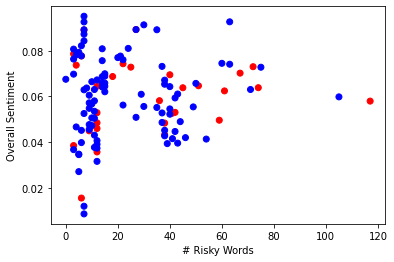

In [ ]:
# color_dict = {'fallen':'r', 'invest':'b'}
# plt.scatter(y = text_data.positive_sentiment_mean-text_data.negetive_sentiment_mean, 
#             x = text_data.risky_words, c= text_data.grade.apply(lambda x: color_dict[x]))
# plt.xlabel('# Risky Words')
# plt.ylabel('Overall Sentiment')

# plt.scatter(text_data.risky_words, text_data.total_words, c= text_data.grade.apply(lambda x: color_dict[x]))

In [ ]:
text_data['date'] = pd.to_datetime(text_data['date'])
text_data = text_data.sort_values(by=  ['cik','date'], ascending= True).reset_index(drop = True)
text_data[text_data['cik'] == 1144519]
# text_data

,filename,text,cik,date,grade,clean_text,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words,fog_index,year
112,./data/processed/txt/invest/0001144519_2004-12...,10-K 1 a2153218z10-k.htm FORM 10-K QuickLinks ...,1144519,2004-12-31,invest,10k 1 a2153218z10k.htm form 10k quicklinks cli...,0.118746,0.158838,0.045956,0.108753,38742,75,11.960581,2004
113,./data/processed/txt/invest/0001144519_2005-03...,10-Q 1 a2157783z10-q.htm FORM 10-Q UNITED STAT...,1144519,2005-03-31,invest,10q 1 a2157783z10q.htm form 10q united state s...,0.142794,0.168242,0.051462,0.099700,9002,30,14.486495,2005
114,./data/processed/txt/invest/0001144519_2005-06...,10-Q 1 a2161887z10-q.htm 10-Q QuickLinks -- Cl...,1144519,2005-06-30,invest,10q 1 a2161887z10q.htm 10q quicklinks click ra...,0.121578,0.158142,0.065937,0.128164,12385,30,13.916105,2005
115,./data/processed/txt/invest/0001144519_2005-09...,10-Q 1 a2164857z10-q.htm 10-Q QuickLinks -- Cl...,1144519,2005-09-30,invest,10q 1 a2164857z10q.htm 10q quicklinks click ra...,0.127065,0.157534,0.066094,0.126130,12979,29,13.699765,2005
116,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,0.116778,0.159499,0.043752,0.098366,39397,72,12.034930,2005
117,./data/processed/txt/invest/0001144519_2006-03...,10-Q 1 a2170198z10-q.htm FORM 10-Q QuickLinks ...,1144519,2006-03-31,invest,10q 1 a2170198z10q.htm form 10q quicklinks cli...,0.145937,0.169145,0.056757,0.105738,11203,35,13.970685,2006
118,./data/processed/txt/invest/0001144519_2006-06...,10-Q 1 a2172491z10-q.htm FORM 10-Q QuickLinks ...,1144519,2006-06-30,invest,10q 1 a2172491z10q.htm form 10q quicklinks cli...,0.136948,0.163651,0.063783,0.117457,14969,37,13.692816,2006
119,./data/processed/txt/fallen/0001144519_2006-09...,10-Q 1 a2174355z10-q.htm 10-Q QuickLinks -- Cl...,1144519,2006-09-30,fallen,10q 1 a2174355z10q.htm 10q quicklinks click ra...,0.143736,0.168690,0.074237,0.136981,15946,40,13.143720,2006


# Fog Score

In [ ]:
import spacy
from textstat.textstat import textstatistics,legacy_round
 
# Splits the text into sentences, using
# Spacy's sentence segmentation which can
# be found at https://spacy.io/usage/spacy-101
nlp = spacy.load('en_core_web_lg')
def break_sentences(text):
    # nlp = spacy.load('en_core_web_lg')
    doc = nlp(text)
    return list(doc.sents)
 
# Returns Number of Words in the text
def word_count(text):
    sentences = break_sentences(text)
    words = 0
    for sentence in sentences:
        words += len([token for token in sentence])
    return words
 
# Returns the number of sentences in the text
def sentence_count(text):
    sentences = break_sentences(text)
    return len(sentences)
 
# Returns average sentence length
def avg_sentence_length(text):
    words = word_count(text)
    sentences = sentence_count(text)
    average_sentence_length = float(words / sentences)
    return average_sentence_length
 
# Textstat is a python package, to calculate statistics from
# text to determine readability,
# complexity and grade level of a particular corpus.
# Package can be found at https://pypi.python.org/pypi/textstat
def syllables_count(word):
    return textstatistics().syllable_count(word)
 
# Returns the average number of syllables per
# word in the text
def avg_syllables_per_word(text):
    syllable = syllables_count(text)
    words = word_count(text)
    ASPW = float(syllable) / float(words)
    return legacy_round(ASPW, 1)
 
# Return total Difficult Words in a text
def difficult_words(text):
    doc = nlp(text)
    # Find all words in the text
    words = []
    sentences = break_sentences(text)
    for sentence in sentences:
        words += [str(token) for token in sentence]
 
    # difficult words are those with syllables >= 2
    # easy_word_set is provide by Textstat as
    # a list of common words
    diff_words_set = set()
     
    for word in words:
        syllable_count = syllables_count(word)
        if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)
 
# A word is polysyllablic if it has more than 3 syllables
# this functions returns the number of all such words
# present in the text
def poly_syllable_count(text):
    count = 0
    words = []
    sentences = break_sentences(text)
    for sentence in sentences:
        words += [token for token in sentence]
     
 
    for word in words:
        syllable_count = syllables_count(word)
        if syllable_count >= 3:
            count += 1
    return count
 
 
 
def gunning_fog(text):
    per_diff_words = (difficult_words(text) / word_count(text) * 100) + 5
    grade = 0.4 * (avg_sentence_length(text) + per_diff_words)
    return grade

text_data['fog_index'] = 0

In [ ]:
text_data.to_csv('sentiment_data_pre_fog.csv')
print(gunning_fog(text_data.clean_text.iloc[0]))

12.034929933614144

In [ ]:
# fog_index

text_data['fog_index'] = text_data.clean_text.progress_apply(lambda x: gunning_fog(x))

  0%|          | 0/124 [00:00<?, ?it/s]

In [ ]:
text_data.to_csv('sentiment_data.csv')
text_data.head()

,filename,text,cik,date,grade,clean_text,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words,fog_index
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,0.116778,0.159499,0.043752,0.098366,39397,72,12.034930
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,0.020338,0.090538,0.004755,0.044588,4064,6,14.708014
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,0.112517,0.163165,0.023437,0.069721,7228,7,15.203633
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,0.119319,0.158512,0.045622,0.107093,9659,4,14.915270
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,0.103316,0.156175,0.024699,0.084460,6439,3,15.558712


# TF-IDF

In [151]:
text_data.head()

,filename,text,cik,date,clean_text,review_clean_tokanize,postive_sentiment,negative_sentiment,total_words,risky_words,fog_index
0,0000001750_2015-05-31_10-K.txt,10-K 1 a2225345z10-k.htm 10-K Use these links ...,1750,2015-05-31 00:00:00,10k 1 a2225345z10khtm 10k use link rapidly rev...,"[10k, 1, a2225345z10khtm, 10k, use, link, rapi...",0.14,0.04,28486,36,8.182045
1,0000894315_2006-09-30_10-Q.txt,10-Q 1 l22661ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2006-09-30 00:00:00,10q 1 l22661ae10vqhtm developer diversified re...,"[10q, 1, l22661ae10vqhtm, developer, diversifi...",0.19,0.04,19455,28,146.530731
2,0000894315_2006-12-31_10-K.txt,10-K 1 l24241ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2006-12-31 00:00:00,10k 1 l24241ae10vkhtm developer diversified re...,"[10k, 1, l24241ae10vkhtm, developer, diversifi...",0.14,0.03,68034,61,90.189559
3,0000894315_2007-03-31_10-Q.txt,10-Q 1 l25860ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2007-03-31 00:00:00,10q 1 l25860ae10vqhtm developer diversified re...,"[10q, 1, l25860ae10vqhtm, developer, diversifi...",0.18,0.04,14261,23,195.820049
4,0000894315_2007-06-30_10-Q.txt,10-Q 1 l27074ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2007-06-30 00:00:00,10q 1 l27074ae10vqhtm developer diversified re...,"[10q, 1, l27074ae10vqhtm, developer, diversifi...",0.18,0.04,17321,21,166.295835


In [152]:
text_data.shape

(36, 11)